In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import math
from typing import Any, Dict, List, Optional

import rasterio
import contextily
import geopandas
import haversine as hs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests
from tqdm.notebook import tqdm

from huhuha.settings import RAW_DATA_DIR, DATA_DIR
from huhuha.ops_tiles import get_otm_tile
from huhuha.utils import get_elevation, random_float

tqdm.pandas()
sns.set_theme(style='whitegrid')

## Wczytanie zbioru danych

In [7]:
avalnache_data_path =  RAW_DATA_DIR / 'data-avalanche.csv'
df = pd.read_csv(avalnache_data_path)

In [8]:
with pd.option_context('display.max_columns', None):
    display(df.head())

,id,date,massif,sommet,itineraire,description,orientation,caracteristique,origine_principale,origine_secondaire,type_ecoulement_principal,qualite_neige,risque_meteo_france,latitude,longitude,thumbnail,imagesNb,isPrivate,tags,updated,altitude_depart,altitude_arrivee
0,1642072642225,1641942000000,aiguilles d arves,Aiguille de l'Epaisseur,NaN,"b""Apres s'etre decale trop sur la gauche par r...",E,b'',"Ski touring, uphill",NaN,NaN,NaN,Inconnu,45.130920,6.357383,/attached-files/thumbnails/1642072461149-IMG20...,2,False,NaN,1642074353000,3100,0
1,1642001062328,1641942000000,NaN,NaN,Mont Joly,b'Descente du Pcheu au Mont Joly. \r\nDeclench...,E,b'',NaN,NaN,NaN,NaN,Inconnu,45.825902,6.693000,/attached-files/thumbnails/1642000995871-6792F...,1,False,NaN,1642013122000,2500,1180
2,1642005733893,1641855600000,Haute Maurienne,Pointe de Vallonbrun,NaN,"b""Petite avalanche partie spontanement, probab...",SE,b'Wind slab',NaN,NaN,NaN,NaN,3 - MARQUE,45.317667,6.937318,/attached-files/thumbnails/1642005733893-16420...,2,False,NaN,1642005978000,2630,2240
3,1641931532871,1641855600000,Belledonne,pointe du sciallet,"Sommet du sciallet par l'éperon est, permettan...","b""Declenchement de la plaque par 1 skieur. \r\...",E,b'',"Ski touring, downhill",NaN,NaN,NaN,Inconnu,45.212236,6.013909,/attached-files/thumbnails/1641931326001-inbou...,3,False,NaN,1641931532000,2300,2200
4,1641918131562,1641855600000,Mont Thabor,Roche de la Pelle,NaN,"b""Avalanche spontanee partie tres probablement...",NE,b'Soft slab',NaN,NaN,Aerosol,NaN,3 - MARQUE,45.136030,6.551387,/attached-files/thumbnails/1641918131562-16419...,5,False,NaN,1641918700000,2820,2450


Przeformatowanie daty, usnięcie błędnych wspołrzednych

In [ ]:
df = df.drop(df[(df.latitude == 0.0) | (df.longitude == 0.0)].index)
df['date_formated'] = df.date.apply(lambda d: pd.to_datetime(d, unit='ms'))
df['date_updated_formated'] = df.updated.apply(lambda d: pd.to_datetime(d, unit='ms'))

In [ ]:
df

In [6]:
columns_to_keep = ['id', 'date', 'updated', 'massif', 'sommet', 'description', 'orientation', 'latitude', 'longitude']
df = df[columns_to_keep]

Utworzenie `GeoDataFrame` z padnasowego df-a.

In [7]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.longitude, df.latitude, crs="EPSG:4326"))

In [8]:
gdf.head(2)

,id,date,updated,massif,sommet,description,orientation,latitude,longitude,geometry
0,1642072642225,1641942000000,1642074353000,aiguilles d arves,Aiguille de l'Epaisseur,"b""Apres s'etre decale trop sur la gauche par r...",E,45.130920,6.357383,POINT (6.35738 45.13092)
1,1642001062328,1641942000000,1642013122000,NaN,NaN,b'Descente du Pcheu au Mont Joly. \r\nDeclench...,E,45.825902,6.693000,POINT (6.69300 45.82590)


## Naniesienie punktów na mapę

Cały świat

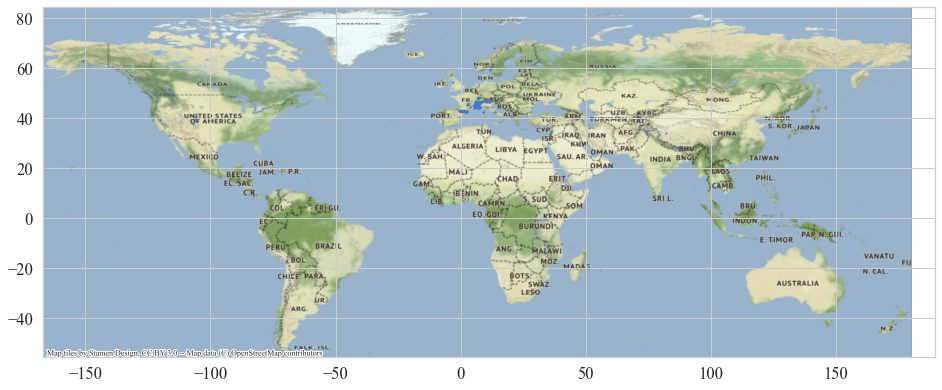

In [10]:
ax = gdf.plot(markersize=1,figsize=(16, 10))
contextily.add_basemap(ax, crs=gdf.crs.to_string())

Europa

In [11]:
gdf_europe = gdf[(gdf.latitude > 15) & (gdf.latitude < 70.0) & (gdf.longitude > - 15.0) & (gdf.longitude < 40.0)]

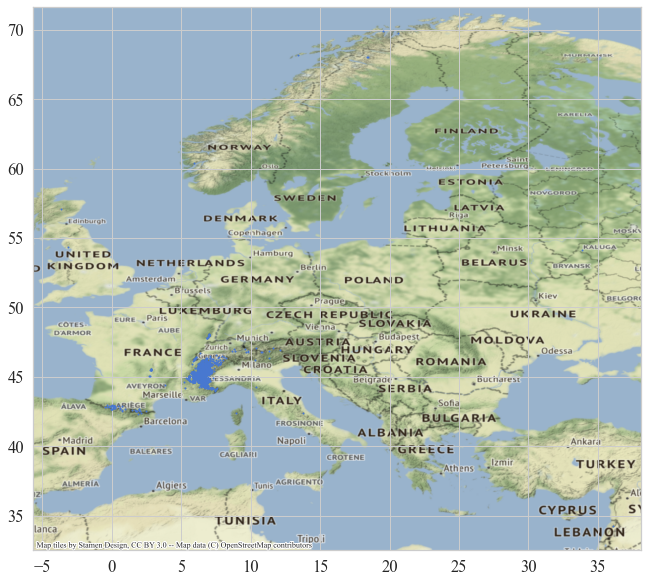

In [12]:
ax = gdf_europe.plot(markersize=1,figsize=(12, 10))
contextily.add_basemap(ax, crs=gdf_europe.crs.to_string())

Alpy -- rejon Francji

In [39]:
ALPS_LAT_LOWER = 44
ALPS_LAT_UPPER = 47.5
ALPS_LONG_LOWER = 5
ALPS_LONG_UPPER = 8.5

gdf_french_alps = gdf[(gdf.latitude > ALPS_LAT_LOWER) & (gdf.latitude < ALPS_LAT_UPPER) & 
                      (gdf.longitude > ALPS_LONG_LOWER) & (gdf.longitude < ALPS_LONG_UPPER)]

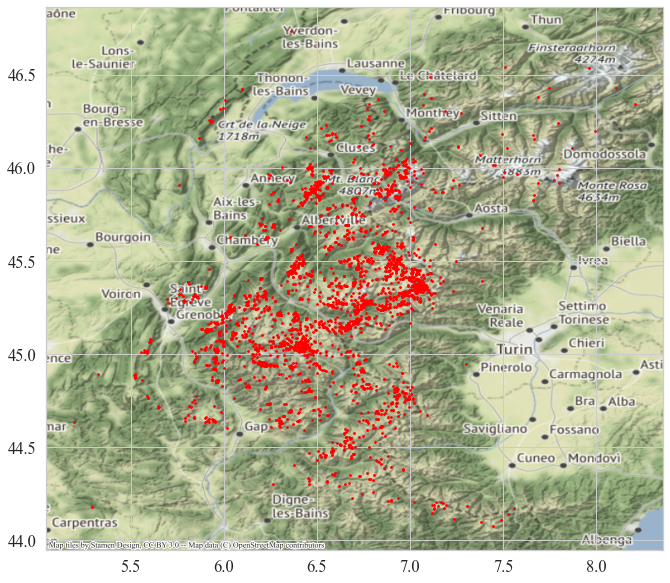

In [40]:
ax = gdf_french_alps.plot(markersize=3, color='red', figsize=(12, 10))
contextily.add_basemap(ax, crs=gdf_french_alps.crs.to_string())

In [41]:
def plot_img(img, cmap='gray', title: Optional[str] = None, figsize=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        
    ax.imshow(img, cmap=cmap)
    ax.axis('off')
    if title is not None:
        ax.set_title(title)
        
def try_download_tile(lat: float, lon: float, zoom: int = 16) -> Optional[str]:
    try:
        tile, filename = get_otm_tile(lat, lon, zoom=ZOOM_VALUE)
        return filename
    except Exception as e:
        print(e)
        return 'None'


## Pobranie _tile_-i map dla lokalizacji z lawinami

In [42]:
ZOOM_VALUE = 16

gdf_french_alps[f'tile_filename_zoom_{ZOOM_VALUE}'] = gdf_french_alps.progress_apply(
    lambda row: try_download_tile(row.latitude, row.longitude, zoom=ZOOM_VALUE), axis=1)

  0%|          | 0/3297 [00:00<?, ?it/s]

D:\Wojtek\Studia\Sztuczna Inteligencja\Semestr 2\Przetwarzanie Danych Przestrzennych\Projekt\huhuha\.venv\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [43]:
gdf_french_alps[gdf_french_alps.tile_filename_zoom_16 != 'None']

,id,date,updated,massif,sommet,description,orientation,latitude,longitude,geometry,tile_filename_zoom_16
0,1642072642225,1641942000000,1642074353000,aiguilles d arves,Aiguille de l'Epaisseur,"b""Apres s'etre decale trop sur la gauche par r...",E,45.130920,6.357383,POINT (6.35738 45.13092),openstreat_map_z_16_x_33925_y_23541.png
1,1642001062328,1641942000000,1642013122000,NaN,NaN,b'Descente du Pcheu au Mont Joly. \r\nDeclench...,E,45.825902,6.693000,POINT (6.69300 45.82590),openstreat_map_z_16_x_33986_y_23360.png
2,1642005733893,1641855600000,1642005978000,Haute Maurienne,Pointe de Vallonbrun,"b""Petite avalanche partie spontanement, probab...",SE,45.317667,6.937318,POINT (6.93732 45.31767),openstreat_map_z_16_x_34030_y_23492.png
3,1641931532871,1641855600000,1641931532000,Belledonne,pointe du sciallet,"b""Declenchement de la plaque par 1 skieur. \r\...",E,45.212236,6.013909,POINT (6.01391 45.21224),openstreat_map_z_16_x_33862_y_23520.png
4,1641918131562,1641855600000,1641918700000,Mont Thabor,Roche de la Pelle,"b""Avalanche spontanee partie tres probablement...",NE,45.136030,6.551387,POINT (6.55139 45.13603),openstreat_map_z_16_x_33960_y_23539.png
...,...,...,...,...,...,...,...,...,...,...,...
3912,1415356829764,38444400000,1415358302000,Maurienne,Rateau d'Aussois,NaN,S,45.217169,6.702358,POINT (6.70236 45.21717),openstreat_map_z_16_x_33988_y_23518.png
3913,50000215,4662000000,1453970425000,Haute Maurienne,Grand Roc Noir,NaN,S,45.327066,6.891223,POINT (6.89122 45.32707),openstreat_map_z_16_x_34022_y_23490.png
3935,1551114492230,-280976400000,1551115398000,Maurienne,Modane - La Freney,NaN,N,45.198635,6.609403,POINT (6.60940 45.19864),openstreat_map_z_16_x_33971_y_23523.png
3948,1417037422856,-881028000000,1417037668000,Maurienne,Saint Colomban des Villards,NaN,NE,45.293951,6.226351,POINT (6.22635 45.29395),openstreat_map_z_16_x_33901_y_23499.png


In [44]:
gdf_french_alps['Avalanche'] = 1

D:\Wojtek\Studia\Sztuczna Inteligencja\Semestr 2\Przetwarzanie Danych Przestrzennych\Projekt\huhuha\.venv\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


## Zebranie przykładów bez lawin

In [73]:
ALPS_LAT_LOWER = 44
ALPS_LAT_UPPER = 47.5
ALPS_LONG_LOWER = 5
ALPS_LONG_UPPER = 8.5

NEGATIVE_SAMPLES_NUM = 4000
MIN_DISTANCE = 1.5 # [km}

negative_points = []
avalanche_points = [(lat, long) for lat, long in zip(gdf_french_alps.latitude.values, gdf_french_alps.longitude.values)]

with tqdm(total=NEGATIVE_SAMPLES_NUM) as pbar:
    while len(negative_points) < NEGATIVE_SAMPLES_NUM:
        latitude = random_float(ALPS_LAT_LOWER, ALPS_LAT_UPPER)
        longitude = random_float(ALPS_LONG_LOWER, ALPS_LONG_UPPER)

        new_loc = (latitude, longitude)
        point_remote_from_avalanche_sites = all([hs.haversine(new_loc, (lat, long)) > MIN_DISTANCE for lat, long in 
             zip(avalanche_points_latitudes, avalanche_points_longitudes)])

        if point_remote_from_avalanche_sites:
            negative_points.append(new_loc)
            pbar.update(1)
    

  0%|          | 0/4000 [00:00<?, ?it/s]

In [76]:
df_negative = pd.DataFrame(negative_points, columns=['latitude', 'longitude'])

In [79]:
gdf_negative = geopandas.GeoDataFrame(
    df_negative, 
    geometry=geopandas.points_from_xy(df_negative.longitude, df_negative.latitude, crs="EPSG:4326")
)

In [80]:
gdf_negative['Avalanche'] = 0

In [81]:
gdf_negative

,latitude,longitude,geometry,Avalanche
0,46.878382,5.753920,POINT (5.75392 46.87838),0
1,44.848302,6.059583,POINT (6.05958 44.84830),0
2,46.619891,7.173702,POINT (7.17370 46.61989),0
3,44.391652,7.509695,POINT (7.50969 44.39165),0
4,47.460847,5.560246,POINT (5.56025 47.46085),0
...,...,...,...,...
3995,45.302965,7.445604,POINT (7.44560 45.30296),0
3996,46.894354,7.161388,POINT (7.16139 46.89435),0
3997,45.136403,7.952573,POINT (7.95257 45.13640),0
3998,47.266752,7.865414,POINT (7.86541 47.26675),0


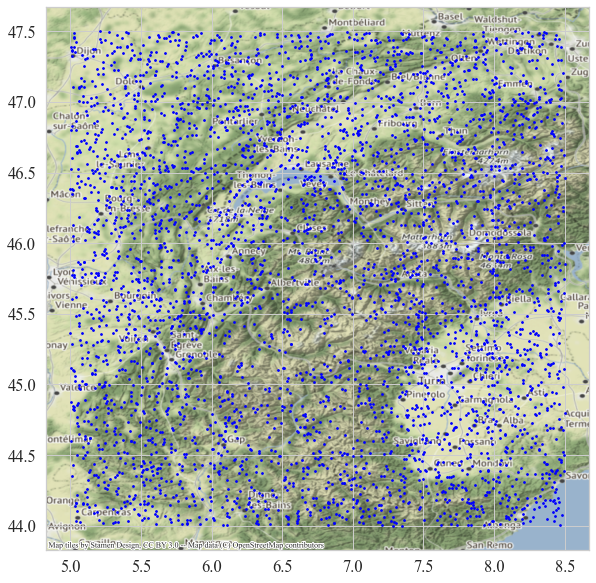

In [82]:
ax = gdf_negative.plot(markersize=3, color='blue', figsize=(12, 10))
contextily.add_basemap(ax, crs=gdf_negative.crs.to_string())

In [84]:
gdf_negative[f'tile_filename_zoom_{ZOOM_VALUE}'] = gdf_negative.progress_apply(
    lambda row: try_download_tile(row.latitude, row.longitude, zoom=ZOOM_VALUE), axis=1)

  0%|          | 0/4000 [00:00<?, ?it/s]

Error 404
[Errno 2] No such file or directory: 'D:\\Wojtek\\Studia\\Sztuczna Inteligencja\\Semestr 2\\Przetwarzanie Danych Przestrzennych\\Projekt\\huhuha\\data\\opentopomap_tiles\\zoom_16\\openstreat_map_z_16_x_33795_y_23322.png'
Error 404
[Errno 2] No such file or directory: 'D:\\Wojtek\\Studia\\Sztuczna Inteligencja\\Semestr 2\\Przetwarzanie Danych Przestrzennych\\Projekt\\huhuha\\data\\opentopomap_tiles\\zoom_16\\openstreat_map_z_16_x_33839_y_23099.png'
Error 404
[Errno 2] No such file or directory: 'D:\\Wojtek\\Studia\\Sztuczna Inteligencja\\Semestr 2\\Przetwarzanie Danych Przestrzennych\\Projekt\\huhuha\\data\\opentopomap_tiles\\zoom_16\\openstreat_map_z_16_x_33722_y_23185.png'
Error 404
[Errno 2] No such file or directory: 'D:\\Wojtek\\Studia\\Sztuczna Inteligencja\\Semestr 2\\Przetwarzanie Danych Przestrzennych\\Projekt\\huhuha\\data\\opentopomap_tiles\\zoom_16\\openstreat_map_z_16_x_33780_y_23014.png'


### Połączenie danych

In [85]:
gdf_whole = pd.concat([gdf_french_alps, gdf_negative])

In [92]:
gdf_whole = gdf_whole[gdf_whole.tile_filename_zoom_16 != 'None']

In [93]:
gdf_whole.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 7293 entries, 0 to 3999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     3297 non-null   float64 
 1   date                   3297 non-null   float64 
 2   updated                3297 non-null   float64 
 3   massif                 3213 non-null   object  
 4   sommet                 2856 non-null   object  
 5   description            2471 non-null   object  
 6   orientation            3297 non-null   object  
 7   latitude               7293 non-null   float64 
 8   longitude              7293 non-null   float64 
 9   geometry               7293 non-null   geometry
 10  tile_filename_zoom_16  7293 non-null   object  
 11  Avalanche              7293 non-null   int64   
dtypes: float64(5), geometry(1), int64(1), object(5)
memory usage: 740.7+ KB


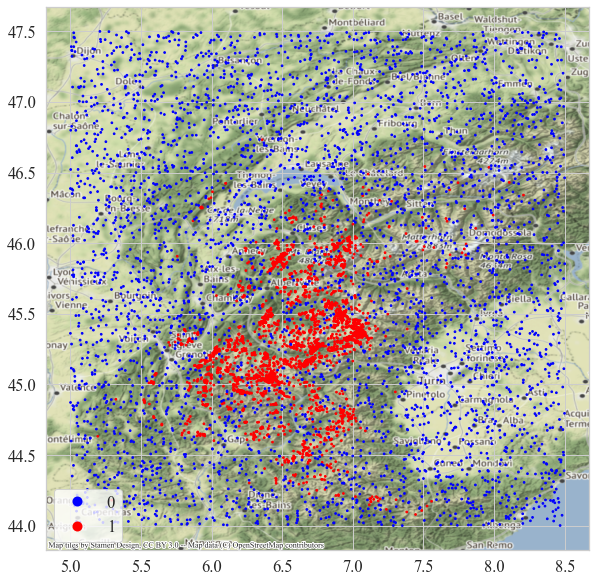

In [109]:
ax = gdf_whole.plot(column='Avalanche', categorical=True, markersize=3, 
                    cmap='bwr', figsize=(12, 10), legend=True)
contextily.add_basemap(ax, crs=gdf_whole.crs.to_string())

## Dodanie danych o wysokości punktu

In [112]:
step=100

elevations = []
for i in tqdm(np.arange(len(gdf_whole), step=step)):
    batch_df = gdf_whole.iloc[i:i+step]
    batch_points = [(lat, long) for lat, long in zip(batch_df.latitude, batch_df.longitude)]
    batch_elevations = get_elevation(batch_points)
    elevations += batch_elevations

  0%|          | 0/73 [00:00<?, ?it/s]

In [114]:
gdf_whole['elevations'] = elevations

D:\Wojtek\Studia\Sztuczna Inteligencja\Semestr 2\Przetwarzanie Danych Przestrzennych\Projekt\huhuha\.venv\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


## Zapis pliku

In [118]:
gdf_whole.to_file(DATA_DIR / 'avalanches-dataset.geojson', driver='GeoJSON')  

## Odczyt pliku

In [2]:
new_gdf = geopandas.read_file(DATA_DIR / 'avalanches-dataset.geojson')

In [6]:
df = pd.DataFrame(new_gdf.drop(columns='geometry'))

In [12]:
df.to_csv(DATA_DIR / 'avalanches-dataset.csv', index=False)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7293 entries, 0 to 7292
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3297 non-null   float64
 1   date                   3297 non-null   float64
 2   updated                3297 non-null   float64
 3   massif                 3213 non-null   object 
 4   sommet                 2856 non-null   object 
 5   description            2471 non-null   object 
 6   orientation            3297 non-null   object 
 7   latitude               7293 non-null   float64
 8   longitude              7293 non-null   float64
 9   tile_filename_zoom_16  7293 non-null   object 
 10  Avalanche              7293 non-null   int64  
 11  elevations             7293 non-null   float64
dtypes: float64(6), int64(1), object(5)
memory usage: 683.8+ KB


<AxesSubplot:title={'center':'Avalanches count'}>

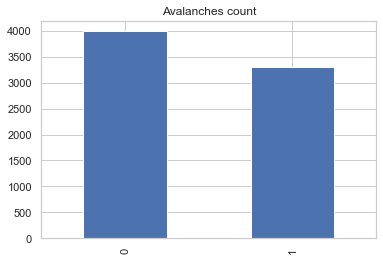

In [11]:
df['Avalanche'].value_counts().plot(kind='bar', title='Avalanches count')